In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import simpy
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

### Chain:
retailer -> wholesaler -> distributor -> factory

### Leadtime:
leadtime ~ U([1,4]) and between all entities

### Demand:
- 15% : 100k
- 15% : 150k
- 70% : 200k

### Cost:
- holding: 0.5
- missing: 1

### Time steps
50

---

## Parameters specification

In [3]:
# define cost matrix 
cost_matrix = {'holding_cost' : 0.5 , 'backlog_cost' : 1}

### define demand distribution
# unit = 1k
# list consist of 100 : #15 , 150 : #15 , 200 : #70
# draw randomly from list to simulate the demand distribution
demand_matrix = [100] * 15 + [150] * 15 + [200] * 70

---

In [10]:
def create_demand_for_retailor(demand_matrix): # provide demand for retailor
    return demand_matrix[np.random.randint(1, len(demand_matrix))]
    

In [11]:
class Chain:
    def __init__(self , env , cost_matrix , start_inventory):
        self.env = env
        self.action = env.process(self.run_simulation())
        self.retailer = Entity(cost_matrix , start_inventory)
        self.wholesaler = Entity(cost_matrix , start_inventory)
        self.distributor = Entity(cost_matrix , start_inventory)
        self.factory = Entity(cost_matrix , start_inventory)
        self.start_inventory = start_inventory
        
    def lead_time(self): # calculate lead time
        return np.random.randint(1 , 5)
    
    def run_simulation(self):
        print(f"Initial inventory : {self.start_inventory}")
        while True:
            # start with customer demand
            customer_demand = create_demand_for_retailor(demand_matrix)
            print('==================================================')
            print(f'Week {env.now}:')
            print('----------')
            print('|Retailer|')
            print('----------')
            # retailer receive demand and handle outbound
            retailer_supply , retailer_demand = self.retailer.react_to_demand(customer_demand , env.now)
            
            
            print('------------')
            print('|Wholesaler|')
            print('------------')
            # wholesaler receive demand from retailer 
            wholesale_supply , wholesale_demand = self.wholesaler.react_to_demand(retailer_demand , env.now)
            # retailer inbound
            lead_time = self.lead_time()
            print(f"Wholesaler -> Retailer , Quantity : {wholesale_supply} , Lead time : {lead_time}")
            self.retailer.inbound_handling(wholesale_supply , env.now + lead_time)
            
            
            print('------------')
            print('|Distributor|')
            print('------------')
            # distributor receive demand from retailer 
            distributor_supply , distributor_demand = self.distributor.react_to_demand(wholesale_demand , env.now)
            # wholesaler inbound
            lead_time = self.lead_time()
            print(f"Distributor -> Wholesaler , Quantity : {distributor_supply} , Lead time : {lead_time}")
            self.wholesaler.inbound_handling(distributor_supply , env.now + lead_time)
            
            print('---------')
            print('|Factory|')
            print('---------')
            # factory receive demand from retailer 
            factory_supply , factory_demand = self.factory.react_to_demand(distributor_demand , env.now)
            # distributor inbound
            lead_time = self.lead_time()
            print(f"Factory -> Distributor , Quantity : {factory_supply} , Lead time : {lead_time}")
            self.distributor.inbound_handling(factory_supply , env.now + lead_time)
            print(f"Factory produce Quantity : {factory_demand}")
            self.factory.inbound_handling(factory_demand , env.now + 1)
            
            
            yield self.env.timeout(1)
    
    def get_entities(self):
        return [self.retailer , self.wholesaler , self.distributor , self.factory]
    
    
    def plot_weekly_cost(self):
        cost_df = pd.DataFrame({'Week' : np.arange(1 , len(self.retailer.cost_log)+1),
                                'Retailer' : self.retailer.cost_log,
                              'Wholesaler' : self.wholesaler.cost_log,
                              'Distributor' : self.distributor.cost_log,
                               'Factory' : self.factory.cost_log})
        # plot
        cost_df.plot(x = 'Week' , y = ['Retailer', 'Wholesaler', 'Distributor', 'Factory'], marker='o')
        plt.xlabel('Time')
        plt.ylabel('Cost')
        plt.title('Cost of each entity(K)')
        plt.show()
        

        
    def plot_inventory(self):
        inventory_df = pd.DataFrame({'Week' : np.arange(1 , 51),
                                'Retailer' : self.retailer.inventory_log[:50],
                              'Wholesaler' : self.wholesaler.inventory_log[:50],
                              'Distributor' : self.distributor.inventory_log[:50],
                               'Factory' : self.factory.inventory_log[:50]})

        inventory_df.plot(x = 'Week' , y = ['Retailer', 'Wholesaler', 'Distributor', 'Factory'], marker='o')
        plt.xlabel('Time')
        plt.ylabel('inventory')
        plt.title('Inventory of each entity(K)')
        plt.show()
        
        
    def plot_weekly_order_placed(self):
        order_placed_df = pd.DataFrame({'Week' : np.arange(1 , len(self.retailer.order_placed)+1),
                                'Retailer' : self.retailer.order_placed,
                              'Wholesaler' : self.wholesaler.order_placed,
                              'Distributor' : self.distributor.order_placed,
                               'Factory' : self.factory.order_placed})
        # plot
        order_placed_df.plot(x = 'Week' , y = ['Retailer', 'Wholesaler', 'Distributor', 'Factory'], marker='o')
        plt.xlabel('Time')
        plt.ylabel('order_placed')
        plt.title('Order placed of each entity(K)')
        plt.show()

In [7]:
class Entity:
    def __init__(self , cost_matrix , start_inventory):
        self.inventory_log = [start_inventory] + [0] * 1000
        self.demand_log = []
        self.cost_log = []
        self.order_placed = []
        self.holding_cost = cost_matrix['holding_cost']
        self.backlog_cost = cost_matrix['backlog_cost']
    
    
    def inbound_handling(self , inbound ,week): # update inbound
        self.inventory_log[week] += inbound
    
    def react_to_demand(self , demand , week):
        self.demand_log.append(demand) # update new demand
        
        quantity_of_product_provide = 0
        cost = 0
        
        print(f"Starting inventory : {self.inventory_log[week]}")
        
        if_backlog = True
        cost = 0
        # handle outbound:
        if demand > self.inventory_log[week]: # if demand > latest inventory
            quantity_of_product_provide = self.inventory_log[week] # set outbound number
            cost = self.backlog_cost * (demand - quantity_of_product_provide)
            self.cost_log.append(cost) # backlog cost
            
        else: # if demand <= latest inventory
            if_backlog = False
            quantity_of_product_provide = demand
            self.inventory_log[week + 1] += (self.inventory_log[week] - demand) # update next day inventory
            cost = self.holding_cost * (self.inventory_log[week] - demand)
            self.cost_log.append(cost) # holding cost
            
        
        # update inventory quantity
        self.inventory_log[week] -= quantity_of_product_provide
        
        print(f"Demand : {demand}") 
        print(f"Ending inventory : {self.inventory_log[week]}")
        if if_backlog:
            print(f'back log cost : {cost}')
        else:
            print(f'holding cost : {cost}')
        
        
        # calculate optimal inventory
        optimal_inventory = self.calculate_optimal_quantity() # calculate the optimal quantity of inventory
        inbound_demand = optimal_inventory - self.inventory_log[week] # calculate difference between current inventory and optimal inventory
        if inbound_demand < 0: # if doesn't need more stock
            inbound_demand = 0
        else:
            pass
        
        self.order_placed.append(inbound_demand) # update order placed
        
        print(f"Optimal holding quantity : {optimal_inventory}")
        print(f"Order placed : {inbound_demand}")

        
        return [quantity_of_product_provide , inbound_demand] # return product supply and demand
        
        
    
    def calculate_optimal_quantity(self): # calculate optimal purchase with newsvendor model
        def min_cost(optimal_q , demand_log , backlog_cost , holding_cost):
            # create a dictionary which contains the percentage of each demandb
            def create_demand_log_dict(demand_log):
                demand_set = set(demand_log) # create list of unique demand
                demand_dict = {} # container to record percentage of different demand
                for demand in demand_set:
                    temp_log_count = 0
                    for log in demand_log:
                        if log == demand:
                            temp_log_count += 1
                    demand_dict.update({demand : temp_log_count}) # record log

                # calculate into percentage
                for key in demand_dict:
                    demand_dict[key] /= len(demand_log)
                return demand_dict

            demand_dict = create_demand_log_dict(demand_log) # get the demand distribution
            total_cost = 0 # store all the costs

            for key in demand_dict: #iterate through different demand
                quant_diff = optimal_q - key
                if quant_diff > 0: # case overage
                    total_cost += abs(quant_diff * holding_cost * demand_dict[key])
                elif quant_diff < 0: # case underage
                    total_cost += abs(quant_diff * backlog_cost * demand_dict[key])
                else:
                    pass
            return total_cost

        def objective(optimal_q):
            return min_cost(optimal_q, self.demand_log , self.backlog_cost, self.holding_cost)

        result = minimize_scalar(objective, bounds=(0, 1e6), method='bounded').x

        return int(round(result , 0))
        
    

## Running

In [12]:
env = simpy.Environment()
chain = Chain(env , cost_matrix , 200) # we set the starting inventory for every entity to be 200k
env.run(until = 50)

Initial inventory : 200
Week 0:
----------
|Retailer|
----------
Starting inventory : 200
Demand : 200
Ending inventory : 0
holding cost : 0.0
Optimal holding quantity : 200
Order placed : 200
------------
|Wholesaler|
------------
Starting inventory : 200
Demand : 200
Ending inventory : 0
holding cost : 0.0
Optimal holding quantity : 200
Order placed : 200
Wholesaler -> Retailer , Quantity : 200 , Lead time : 1
------------
|Distributor|
------------
Starting inventory : 200
Demand : 200
Ending inventory : 0
holding cost : 0.0
Optimal holding quantity : 200
Order placed : 200
Distributor -> Wholesaler , Quantity : 200 , Lead time : 3
---------
|Factory|
---------
Starting inventory : 200
Demand : 200
Ending inventory : 0
holding cost : 0.0
Optimal holding quantity : 200
Order placed : 200
Factory -> Distributor , Quantity : 200 , Lead time : 4
Factory produce Quantity : 200
Week 1:
----------
|Retailer|
----------
Starting inventory : 200
Demand : 100
Ending inventory : 100
holding co

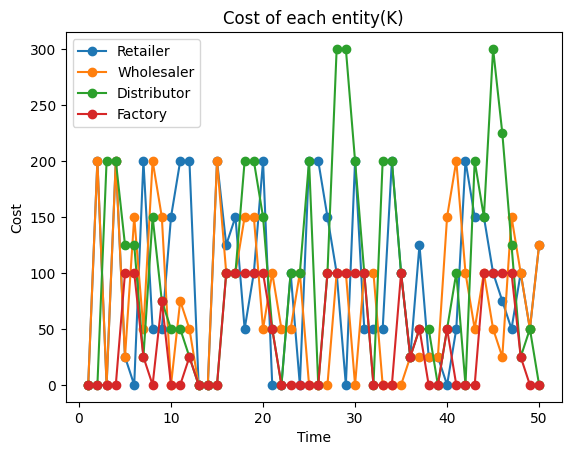

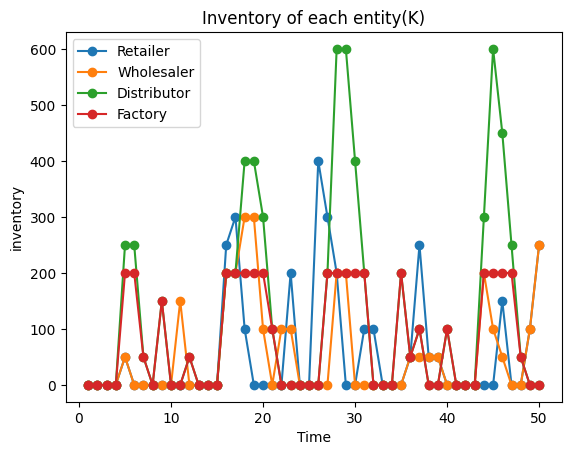

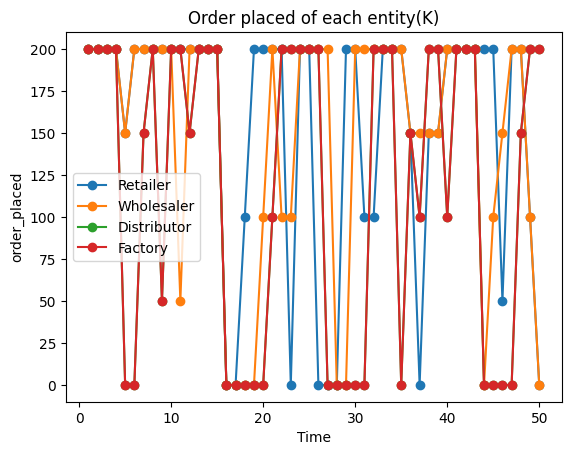

In [86]:
chain.plot_weekly_cost()
chain.plot_inventory()
chain.plot_weekly_order_placed()